# Project 242

## Import

In [351]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [352]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [353]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


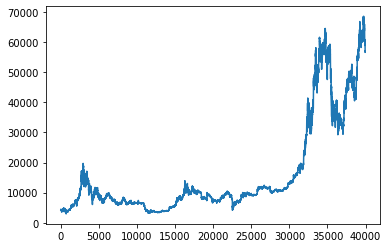

In [354]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [355]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

Here, we can decide to add features ...

In [356]:
# Add features
data = add_technical_indicators(data, lookback_period=30)[30:]

In [357]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [358]:
# Split data
train_data, test_data = split_data(data, split=0.25)


In [359]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [360]:
# Add Signal
train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)

In [361]:
train = prepare_data_2D_format(train_data, lookback_period = 1, undersample = False)
test = prepare_data_2D_format(test_data, lookback_period = 1, undersample = False)
test = test[:-2]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


## II. Model

In [362]:
train.corr()

,open_day_minus1,high_day_minus1,low_day_minus1,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,VWAP_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
open_day_minus1,1.000000,0.999664,0.999516,0.999478,0.333702,0.067537,0.089772,0.996745,0.992840,0.993181,0.997577,0.039179,0.067537,-0.011448
high_day_minus1,0.999664,1.000000,0.999180,0.999672,0.337692,0.064985,0.091426,0.996700,0.993870,0.992132,0.997606,0.041996,0.064985,-0.011340
low_day_minus1,0.999516,0.999180,1.000000,0.999644,0.326508,0.072379,0.095880,0.996095,0.990935,0.993623,0.996859,0.046476,0.072379,-0.011412
close_day_minus1,0.999478,0.999672,0.999644,1.000000,0.332104,0.068637,0.096031,0.996383,0.992456,0.992795,0.997233,0.046205,0.068637,-0.011368
Volume_day_minus1,0.333702,0.337692,0.326508,0.332104,1.000000,-0.021973,0.026602,0.336993,0.339229,0.330390,0.336132,0.001178,-0.021973,-0.009107
MOM_day_minus1,0.067537,0.064985,0.072379,0.068637,-0.021973,1.000000,0.619733,-0.000259,-0.016491,-0.004125,0.004150,0.556981,1.000000,0.010050
RSI_day_minus1,0.089772,0.091426,0.095880,0.096031,0.026602,0.619733,1.000000,0.046999,0.034676,0.043601,0.045001,0.759072,0.619733,0.016244
VWAP_day_minus1,0.996745,0.996700,0.996095,0.996383,0.336993,-0.000259,0.046999,1.000000,0.995660,0.995812,0.999264,-0.004444,-0.000259,-0.011723
BB_high_day_minus1,0.992840,0.993870,0.990935,0.992456,0.339229,-0.016491,0.034676,0.995660,1.000000,0.985614,0.996507,-0.012875,-0.016491,-0.011651
BB_low_day_minus1,0.993181,0.992132,0.993623,0.992795,0.330390,-0.004125,0.043601,0.995812,0.985614,1.000000,0.995907,-0.007366,-0.004125,-0.012335


Many features are highly correlated. It does not seem necessary to keep the open, high and low prices in a day.

In [379]:
from sklearn.linear_model import LogisticRegression
# Create MLR model
logistic_regression = LogisticRegression(multi_class="multinomial")

# Train
log = logistic_regression.fit(train.drop(['Signal'], axis = 1), train['Signal'])

# Check score
y_pred = log.predict(test.drop(['Signal'], axis = 1))

array([1, 1, 1, ..., 1, 1, 1])

### A. Predicting if a signal will be non-negative

In [363]:
train['Signal1'] = (train['Signal']>=0).apply(int)
test['Signal1'] = (test['Signal']>=0).apply(int)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(train.drop(['Signal1'], axis=1), train['Signal1'])
train1 = X_res
train1['Signal1'] = y_res

In [364]:
removed = ['Signal', 'Return', 'Signal1', 'Signal2']
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [365]:
str_formula

'Signal1 ~ open_day_minus1 + high_day_minus1 + low_day_minus1 + close_day_minus1 + Volume_day_minus1 + MOM_day_minus1 + RSI_day_minus1 + VWAP_day_minus1 + BB_high_day_minus1 + BB_low_day_minus1 + EMA_day_minus1 + CCI_day_minus1 + MACD_day_minus1'

In [366]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686579
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21438
Method:                           MLE   Df Model:                           13
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009476
Time:                        23:26:01   Log-Likelihood:                -14728.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 1.521e-52
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4962      0.146     -3.398      0.001      -0.782      -0.210
open_

In [367]:
# feature CCI_day_minus1 has a large P-value, I remove it.
removed.append('CCI_day_minus1')
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686581
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21439
Method:                           MLE   Df Model:                           12
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009473
Time:                        23:26:01   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 3.188e-53
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4712      0.117     -4.020      0.000      -0.701      -0.241
open_

In [368]:
# feature MOM_day_minus1 has a large P-value, I remove it.
removed.append('MOM_day_minus1')
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686581
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21440
Method:                           MLE   Df Model:                           11
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009473
Time:                        23:26:02   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 6.135e-54
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4712      0.117     -4.020      0.000      -0.701      -0.241
open_

In [369]:
# feature MACD_day_minus1 has a large P-value, I remove it.
removed.append('MACD_day_minus1')
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686588
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21441
Method:                           MLE   Df Model:                           10
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009463
Time:                        23:26:02   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 1.298e-54
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4834      0.115     -4.202      0.000      -0.709      -0.258
open_

In [370]:
# feature open_day_minus1 has a large P-value, I remove it.
removed.append('open_day_minus1')
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686591
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21442
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009458
Time:                        23:26:02   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 2.422e-55
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4813      0.115     -4.189      0.000      -0.707      -0.256
high_

In [371]:
# feature VWAP_day_minus1 has a large P-value, I remove it.
removed.append('VWAP_day_minus1')
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]
reg1 = smf.logit(formula  = str_formula, data = train1).fit()

print(reg1.summary())

Optimization terminated successfully.
         Current function value: 0.686601
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                21452
Model:                          Logit   Df Residuals:                    21443
Method:                           MLE   Df Model:                            8
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                0.009444
Time:                        23:26:02   Log-Likelihood:                -14729.
converged:                       True   LL-Null:                       -14869.
Covariance Type:            nonrobust   LLR p-value:                 4.877e-56
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4831      0.115     -4.206      0.000      -0.708      -0.258
high_

### B. Predicting if a signal will be non-positive

In [372]:
train['Signal2'] = (train['Signal']<=0).apply(int)
test['Signal2'] = (test['Signal']<=0).apply(int)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(train.drop(['Signal2'], axis=1), train['Signal2'])
train2 = X_res
train2['Signal2'] = y_res

In [373]:
removed = ['Signal', 'Return', 'Signal1', 'Signal2']
str_formula = 'Signal2 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [374]:
str_formula

'Signal2 ~ open_day_minus1 + high_day_minus1 + low_day_minus1 + close_day_minus1 + Volume_day_minus1 + MOM_day_minus1 + RSI_day_minus1 + VWAP_day_minus1 + BB_high_day_minus1 + BB_low_day_minus1 + EMA_day_minus1 + CCI_day_minus1 + MACD_day_minus1'

In [375]:
# at first I will use all features
# fitting data to the model
reg2 = smf.logit(formula  = str_formula, data = train2).fit()

print(reg2.summary())

Optimization terminated successfully.
         Current function value: 0.684322
         Iterations 4


LinAlgError: Singular matrix

### C. Prediction

In [ ]:
y_prob1 = reg1.predict(test)
y_prob2 = reg2.predict(test)

def MultiClassifier(a,b):
    if a > 0.5 and b > 0.5: return 0
    if a > b: return 1
    return -1


y_pred = [MultiClassifier(y_prob1[i],y_prob2[i]) for i in range(len(y_prob1))]
y_test = test['Signal']

In [ ]:
{0: len([0 for x in y_pred if x==0]), 
 1: len([0 for x in y_pred if x==1]),
 -1: len([0 for x in y_pred if x==-1])}

### 3. Test prediction model

In [ ]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [ ]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

### III. Strategy

### 1. Get data ready for backtesting

In [ ]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

In [ ]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [ ]:
strat = Strategy(cash=500, fees=0.001)

In [ ]:
strat.run(signal_crop, close_crop, verbose=False)

In [ ]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

In [ ]:
strat.visualize()

### 3. Test performance startegy

In [ ]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [ ]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)